# Mini-project 5.3 Detecting the anomalous activity of a ship’s engine

##Exploratory Data Analysis

In [ ]:
# Import the necessary libraries.
import pandas as pd
import numpy as np#
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [ ]:
#Import the data with a URL link
df = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv')

#display the first few rows of data
print(df.shape)
df.head()

(19535, 6)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [ ]:
#determine metadata of Data Frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


In [ ]:
#Calculate descriptive statistics for each feature
df.describe(percentiles=[0.05,0.25,0.75,0.95]).round()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.0,19535.0,19535.0,19535.0,19535.0,19535.0
mean,791.0,3.0,7.0,2.0,78.0,78.0
std,268.0,1.0,3.0,1.0,3.0,6.0
min,61.0,0.0,0.0,0.0,71.0,62.0
5%,443.0,2.0,3.0,1.0,74.0,68.0
25%,593.0,3.0,5.0,2.0,76.0,74.0
50%,746.0,3.0,6.0,2.0,77.0,78.0
75%,934.0,4.0,8.0,3.0,78.0,83.0
95%,1324.0,5.0,12.0,4.0,85.0,89.0
max,2239.0,7.0,21.0,7.0,90.0,196.0


In [ ]:
#check for duplicate values
duplicate_counts = df.duplicated(keep=False).sum()
duplicate_counts

np.int64(0)

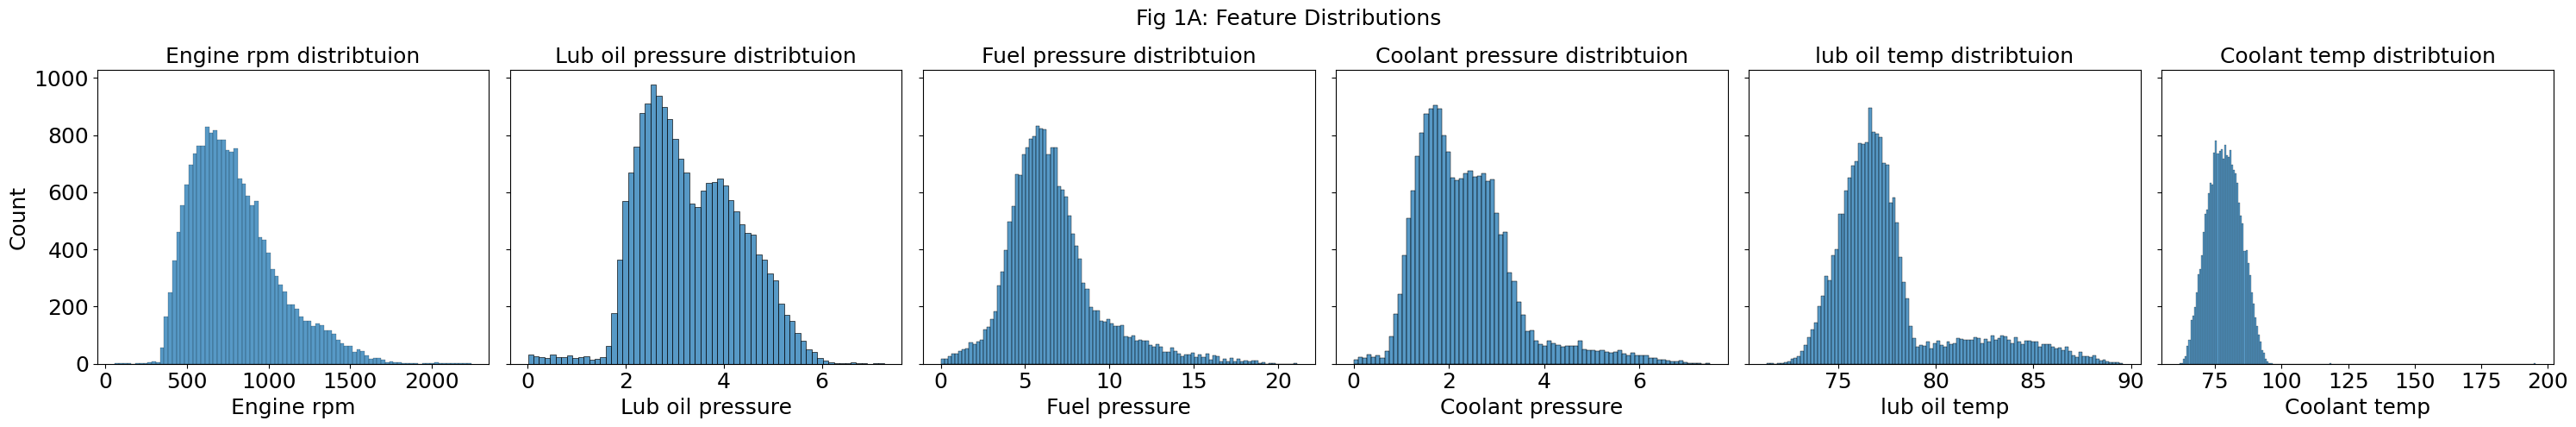

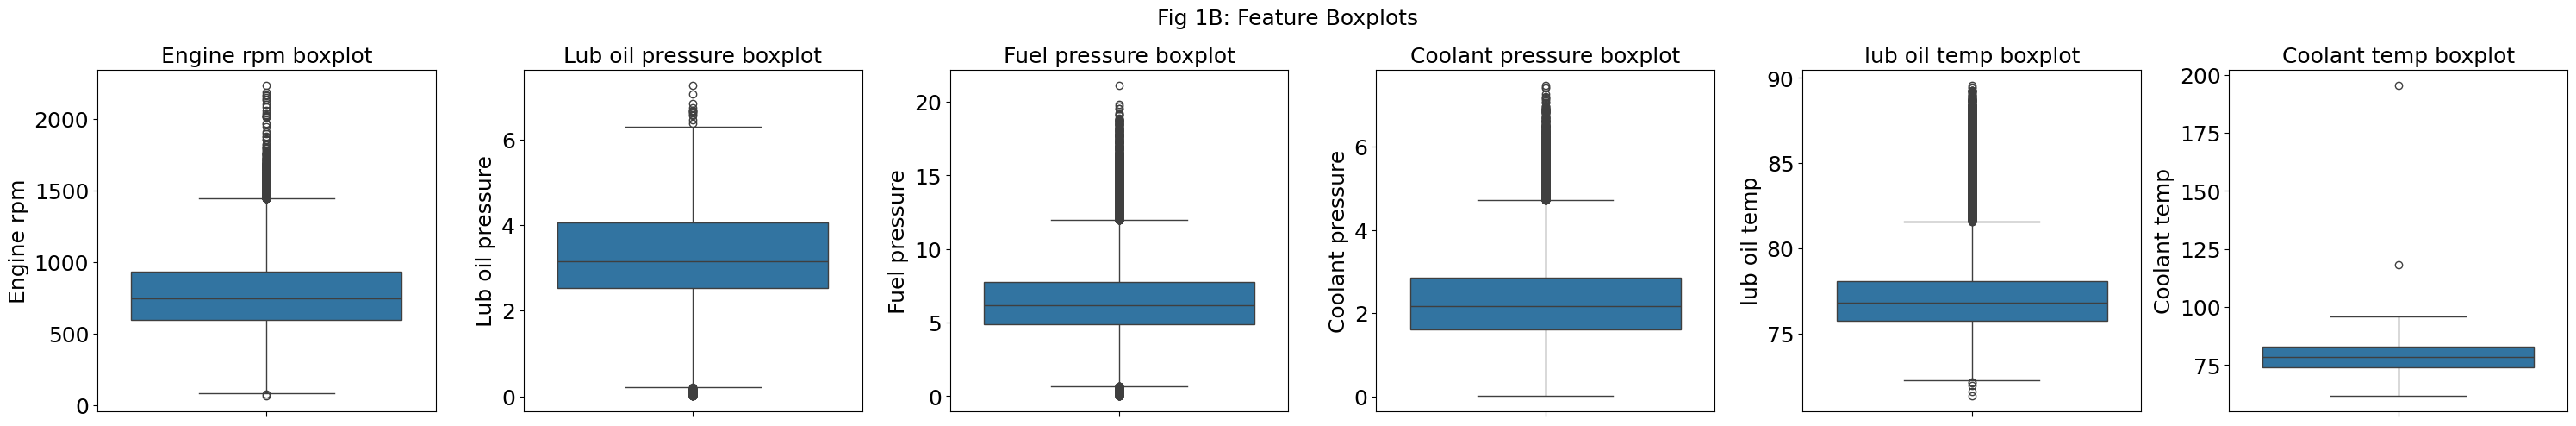

In [ ]:
#check the distribution of the data, and check for any initial outliers
fig, axes = plt.subplots(1, len(df.columns), figsize=(16,4),sharey=True)
j=0
for feature in list(df.columns):
    sns.histplot(df[feature], ax =axes[j])
    axes[j].set_title(f"{feature} distribtuion",fontsize=18)
    axes[j].set_xlabel(f"{feature}", fontsize=18)
    axes[j].set_ylabel('Count', fontsize=18)
    axes[j].tick_params(axis='x', labelsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    fig.suptitle('Fig 1A: Feature Distributions',fontsize=18)
    fig.set_size_inches(30,5)
    plt.tight_layout()
    j+=1

fig, axes = plt.subplots(1, len(df.columns), figsize=(16,4))
j=0
for feature in list(df.columns):
    sns.boxplot(df[feature], ax =axes[j])
    axes[j].set_title(f"{feature} boxplot", fontsize=18)
    axes[j].set_ylabel(f"{feature}", fontsize=18)
    axes[j].tick_params(axis='x', labelsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    fig.suptitle('Fig 1B: Feature Boxplots',fontsize=18)
    fig.set_size_inches(30,5)
    plt.tight_layout()
    j+=1


Initial exploration shows that the engine features are largely normally distributed (some slightly skewed to the right / left), with several outliers, making IQR a good method to detect anomalies. Note that there are no null or duplicated rows to handle in this dataset, and all features are relevant for predicting an engine's health and therefore to detect outliers.

## Method 1. Using IQR method to identify outliers

In [ ]:
df_iqr = df.copy()
#calculate the individual quantiles and iqr
q1 = df_iqr['Engine rpm'].quantile(0.25)
q3 = df_iqr['Engine rpm'].quantile(0.75)
iqr = q3 - q1

#calculate the lower and upper bounds to detect anomalies
lower = q1-1.5*iqr
upper = q3+1.5*iqr

In [ ]:
for feature in list(df_iqr.columns):
    #calculate the individual quantiles and iqr
    label = feature + '_flagged'
    q1 = df_iqr[feature].quantile(0.25)
    q3 = df_iqr[feature].quantile(0.75)
    iqr = q3 - q1
    #calculate the lower and upper bounds to detect anomalies
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    #assign value 1 to the anomalies in each column
    df_iqr[label] = np.where(((df_iqr[feature] > upper) | (df_iqr[feature] < lower)),1,0)

In [ ]:
#calculate how many features are considered outliers in total
df_iqr['total flag'] = df_iqr.iloc[:,6:].sum(axis=1)
#check calculation is correct
df_iqr.sort_values(by='total flag',ascending=False)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm_flagged,Lub oil pressure_flagged,Fuel pressure_flagged,Coolant pressure_flagged,lub oil temp_flagged,Coolant temp_flagged,total flag
5429,705,4.111175,14.968655,4.994738,81.682039,84.052208,0,0,1,1,1,0,3
685,1470,2.957604,7.951829,4.786933,87.439237,78.906216,1,0,0,1,1,0,3
10111,877,5.073764,12.687559,4.749380,82.738746,83.397683,0,0,1,1,1,0,3
6254,901,4.943030,13.686792,5.063884,85.377813,74.991807,0,0,1,1,1,0,3
11395,1454,3.753531,6.419388,5.087253,88.609946,87.551464,1,0,0,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,636,2.948588,8.241496,1.603851,78.863452,75.693220,0,0,0,0,0,0,0
7371,422,2.809132,1.848680,3.471422,75.988046,74.166874,0,0,0,0,0,0,0
7369,737,4.699707,6.175905,1.931675,75.017812,86.780352,0,0,0,0,0,0,0
7367,1216,2.275987,4.950498,1.283624,80.789527,75.962355,0,0,0,0,0,0,0


In [ ]:
#what is the ideal number of flags to identify outliers in the dataset so that they only account for 1-5% of the data?
for i in range(1,6):
    print('Total number of observations with', i, 'or more flagged features:', round(df_iqr[df_iqr['total flag']>=i].shape[0]),', percentage of dataset:',round(df_iqr[df_iqr['total flag']>=i].shape[0]/19535*100,1),'%')

Total number of observations with 1 or more flagged features: 4636 , percentage of dataset: 23.7 %
Total number of observations with 2 or more flagged features: 422 , percentage of dataset: 2.2 %
Total number of observations with 3 or more flagged features: 11 , percentage of dataset: 0.1 %
Total number of observations with 4 or more flagged features: 0 , percentage of dataset: 0.0 %
Total number of observations with 5 or more flagged features: 0 , percentage of dataset: 0.0 %


Based on the analysis above, a ship engine should be identified as an anomaly if two or more features are considered an outlier. While IQR is well suited to skewed data, results should be treated with caution as it can only be performed on one column at a time. It may be that a specific combination of feature outliers for a given observation is more indicative of a problem, which IQR would not capture.

##Create a PCA Data Frame with 2 Dimensions for visualisations later

In [ ]:
#PCA, and one class SVM later recquires scaled data as they are distance based models
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#check scaler has worked correctly
df_scaled.describe().round(3)
#transforming to 2D so that we can visualise the data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
print("Standardised data: ", df_scaled.shape)
print("PCA data for visualisation: ", df_pca.shape)

Standardised data:  (19535, 6)
PCA data for visualisation:  (19535, 2)


##Method 2: One Class SVM

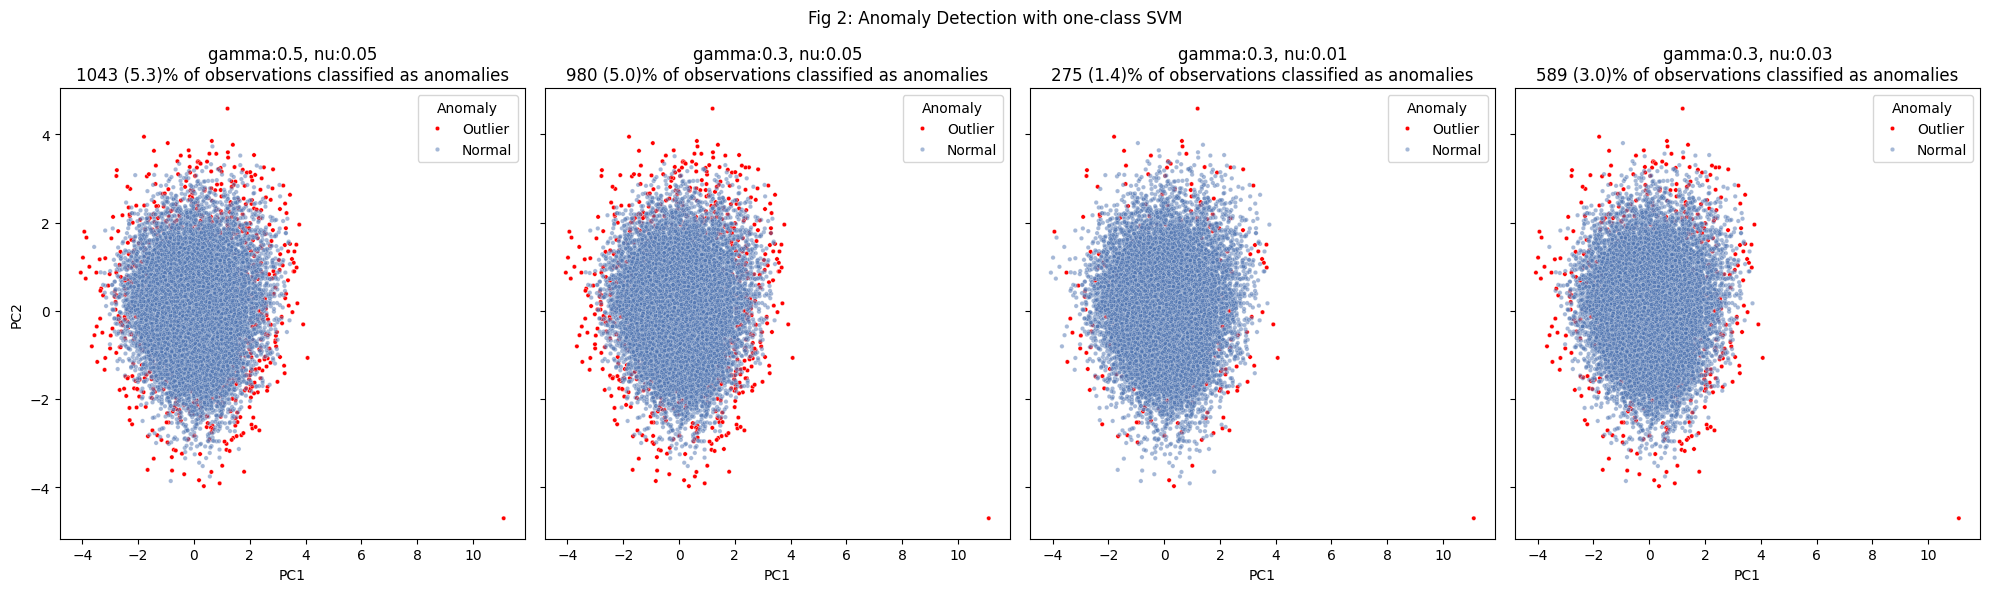

In [ ]:
#create a function for svm model so I can easily change gamma and nu combinations and compare results
def svm_model(gamma_nu):
    fig, axes = plt.subplots(1, len(gamma_nu), figsize=(20,6),sharey=True)
    j=0
    for i in gamma_nu:
        #Apply one class SVM
        model = OneClassSVM(kernel='rbf', gamma=i[0], nu=i[1])
        model.fit(df_scaled)
        #Identify anomalies
        y_pred=pd.DataFrame(model.predict(df_scaled))
        df_svm = df_scaled.copy()
        df_svm['anomaly'] = y_pred
        num=round(df_svm[df_svm['anomaly']==-1].shape[0])
        perc=round(df_svm[df_svm['anomaly']==-1].shape[0]/19535*100,1)
        df_svm2 = pd.merge(pd.DataFrame(df_pca), y_pred, left_index=True,right_index=True)
        df_svm2.columns=['PC1', 'PC2', 'Anomaly']
        df_svm2['Anomaly'] = np.where(df_svm2['Anomaly']==-1,'Outlier','Normal')
        df_anom = df_svm2[df_svm2['Anomaly']=='Outlier']
        df_norm = df_svm2[df_svm2['Anomaly']=='Normal']
        #plot results
        sns.scatterplot(x=df_anom['PC1'],y=df_anom['PC2'],hue=df_anom['Anomaly'],palette=['r'],s=10,ax =axes[j])
        sns.scatterplot(x=df_norm['PC1'],y=df_norm['PC2'],hue=df_norm['Anomaly'],palette='deep',s=10,alpha=0.5,ax =axes[j])
        axes[j].set_title(f'gamma:{i[0]}, nu:{i[1]}\n{num} ({perc})% of observations classified as anomalies')
        j+=1
    fig.suptitle('Fig 2: Anomaly Detection with one-class SVM')
    plt.tight_layout()
gamma_nu = [(0.5, 0.05),(0.3, 0.05),(0.3,0.01),(0.3,0.03)]
svm_model(gamma_nu)

While one-class SVM is very powerful, it becomes difficult to interpret the results. It is not clear from the visualisation why one point may be selected over a neighbouring point. Performing dimensionality reduction to visualise the data can also lead to loss of information, which may lead to the wrong selection of parameters.

##Method 3: Isolation Forest

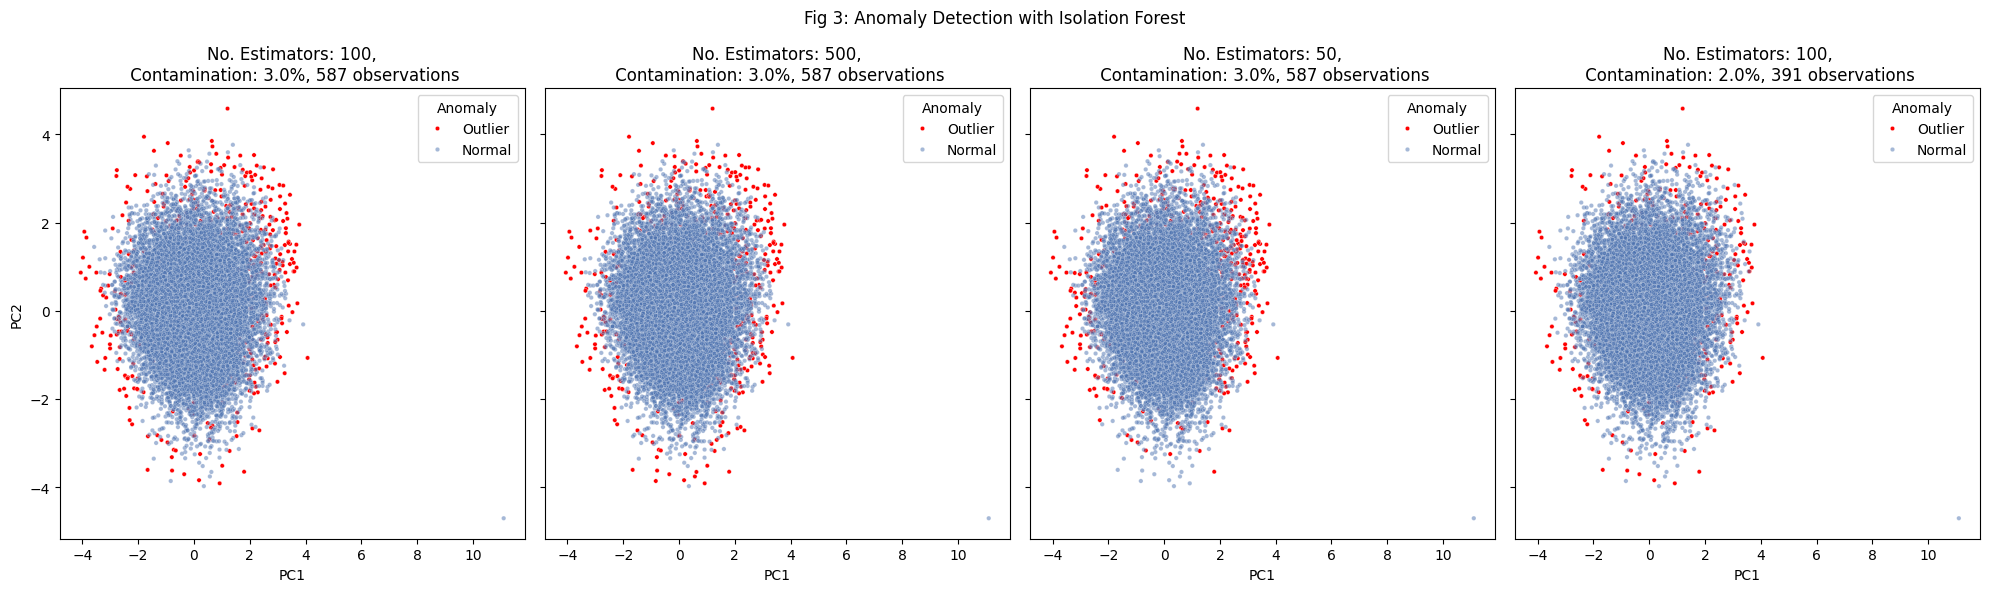

In [ ]:
def iso_forest_model(parameters):
    fig, axes = plt.subplots(1, len(parameters), figsize=(20,6),sharey=True)
    j=0
    #create a loop to iterate through different contamination levels, identify outliers and plot results
    for i in parameters:
            #apply the isolation forest model
            iso_forest= IsolationForest(n_estimators=i[0],contamination=i[1], random_state=42)
            iso_forest.fit(df)
            iso_pred = iso_forest.predict(df)
            iso_df = pd.merge(pd.DataFrame(df_pca), pd.DataFrame(iso_pred), left_index=True,right_index=True)
            iso_df.columns=['PC1', 'PC2', 'Anomaly']
            num=round(iso_df[iso_df['Anomaly']==-1].shape[0])
            iso_df['Anomaly'] = np.where(iso_df['Anomaly']==-1,'Outlier','Normal')
            #identify the anomalies in the dataset
            df_anom_iso = iso_df[iso_df['Anomaly']=='Outlier']
            df_norm_iso = iso_df[iso_df['Anomaly']=='Normal']
            #create a scatterplot to visualise the data
            sns.scatterplot(x=df_anom_iso['PC1'],y=df_anom_iso['PC2'],hue=df_anom_iso['Anomaly'],palette=['r'],s=10,ax =axes[j])
            sns.scatterplot(x=df_norm_iso['PC1'],y=df_norm_iso['PC2'],hue=df_norm_iso['Anomaly'],palette='deep',s=10,alpha=0.5,ax =axes[j])
            axes[j].set_title(f'No. Estimators: {i[0]},\n Contamination: {i[1]*100}%, {num} observations')
            j+=1
    fig.suptitle('Fig 3: Anomaly Detection with Isolation Forest')
    plt.tight_layout()

parameters = [(100, 0.03),(500, 0.03),(50,0.03),(100,0.02)]
iso_forest_model(parameters)

Similar to one-class SVM there is a loss of interpretability, however isolation forest is able to directly set the contamination rate, and was significantly faster to run, which if the dataset were to expand, could make a significant difference. Isolation forest is also much better at detecting complex relationships that IQR could not.

# Reflect

While all these techniques have their place and their value, for this assignment, isolation forest is the most sensible choice.


### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]